# Bayesian analysis of performance 

This notebook reevaluates the performance of a binary classifier by using the Bayes rule. As an example, we'll use the performance of two lie detectors that are being proposed to perform massive screening of migrants and/or refugees.

Although the scientific consensus is that lie detectors do not exist [0], in this post we will not discuss this issue neither we won't discuss assumptions of the methods, experimental validation, etc. Rather we will try to analyze the actual feasibility of the solutions that the projects and authors propose considering all the assumptions they do about their inventions hold.

## Summary of a test

A test is a method to detect events such as cancer, spam, deception, etc. There are four outcomes of a test: 
- **True positive**: the test says the person lies, and the person lied. 
- **False positive**: the test says person lies, and actually the person didn't lie.
- **True negative**: the test says the person doesn't lie, and they didn't. 
- **False negative**: the test says the person doesn't lie, and they lied.

These outcomes can be represented in the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), for instance, the reported performance of iBorderCtrl is (see Table IV in [5]): 

| Test Result\Ground Truth | Lie    | no-lie |
| ------------------------ | ------ | ------ |
| Test positive            | 75.55% | 24.45% |
| Test negative            | 26.34% | 73.66% |

How we interpret this performance: 

- If the person lies, there is a 75.55% of chances of having a positive test (true positive) and 24.45% of having a negative test (false negative). 
- If the person tells the truth, there is a 26.34% of chance the test will be positive (false positive) and 73.66% the test will be negative (true positive). 

We want to answer the question: *provided we have a positive test, what is the probability the person is lying?*

Some notes on tests and probability (adapted from [1]):
- **Tests are not the event**. A test for detecting lying is a separate event from actually lying. 
- **Tests are flawed**. Tests detect things that don’t exist (false positive) and miss things that do exist (false negative). People often use test results without adjusting for test errors.
- **Bayes’ theorem** estimates the real probability of an event from the test results, so we can correct the estimation of the error.

## Bayes' Theorem


<figure>
  <img src="pics/Bayes_Theorem.png"" alt="Trulli" style="width:50%">
  <figcaption style="text-align:center" >Bayes' Theorem summary. Source <a href="https://betterexplained.com/articles/an-intuitive-and-short-explanation-of-bayes-theorem/">Betterexplained</a>.</figcaption>
</figure> 

The probability of an event is the number of ways it could happen given all possible outcomes. In our case:

\begin{align}
\text{Probability} &= \frac{\text{desired event}}{\text{all posibilities}} \\
P(\text{Lie}\mid\text{+}) &= \frac{P(\text{+}\mid\text{Lie}) P(\text{Lie})}{P(+)} \\
 &= \frac{P(\text{+}\mid\text{Lie}) P(\text{Lie})}{P(\text{+}\mid\text{Lie}) P(\text{Lie}) + P(\text{+}\mid\text{Non-lie}) P(\text{Non-lie})} 
\end{align}

where:
- $P(\text{Lie}\mid\text{+})$ is the probability of having a lier ($\text{Lie}$) given a positive test ($\text{+}$), formally the *posterior probability*. 
- $P(\text{+}\mid\text{Lie})$ is the chance of having a positive test ($\text{+}$) when the person is lying $(\text{Lie}$). This is the chance of true positive (75.55% in our example).
- $P(Lie)$ is the chance of having of persons that would lie in an interview, formally *prior probability*. It can be also refered to as *frequency* or *prevalence*.
- $P(Non-lie)$ is the chance of having a person that is telling the truth ($P(Non-lie)=1-P(Lie)$). 
- $P(\text{+}\mid\text{Non-lie})$ is the chance of having a positive test ($\text{+}$) when the person is not lying $(\text{Non-lie}$). This is a false positive (26.34% in our example).

## Formulating hypothesis of scenarios

$Lie$ is called *hypothesis* whose probability may be affected by data (evidence or test). By varying $P(Lie)$ we can observe the variation of the posterior probability under different hypotheses. For example, we can calculate the posterior with the hypothesis of 10% of liers ($P(Lie)=0.1$) in the population that will be screened:

\begin{align}
P(\text{Lier}\mid\text{+}) &= \frac{0.7555 \times 0.10}{0.7555 \times 0.10 + 0.2634 \times 0.90} \\
&\approx 24.16\%\\
P(\text{No-lier}\mid\text{+}) &= 1-P(\text{Lier}\mid\text{+})=1-0.2416  \\
&\approx 75.84\%
\end{align}

This means that, in a scenario of 10% of liers, 24.16% of positive tests will correspond to actual liers crossing the borders and 75.84% will correspond to false positives. For example, if we have 1,000 people being interviewed, $\approx$ 758 of *innocent* people will be labeled as liers. This performance decay together with our bad intuition, as humans, about rare events is explained by the [base rate fallacy](https://en.wikipedia.org/wiki/Base_rate_fallacy).

## Python example code

We can better observe how the test behaves for different base rates by testing different values of $P(Lie)$.

The following code calculates the posterior probability for finding an actual liar given a positive test:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# E is the test
# H is the hypothesis

def posterior(PrEH, PrH, PrEnH):
    PrnH = 1 - PrH
    PrHE = (PrEH * PrH) / (PrEH * PrH + PrEnH * PrnH)
    return PrHE

### iBorderCtlr

The [iBorderCtlr](http://iborderctrl.eu/) is an EU funded project to develop a intelligent portable control system for borders. The project features many of the components of smart borders systems (biometrics, document authentication, etc.) but it also performs *risk-scoring* of travelers and *automated deception detection* to evaluate travelers and migrants at the border. 

We can get $P(\text{+}\mid\text{Lie})$ and $P(\text{+}\mid\text{No-Lie})$ iBorderCtlr last publication [5]:

In [2]:
# Pr(E|H) Chance of a positive test (E) given there is a liar (H). This is the chance of a true positive.
PrEH = 0.7555
# Chance of a positive test (E) given that the person wasn't a lying. This is the probability of a  false positive
PrEnH = 0.2634

We can build the corrected/posterior chances of true positives and false positives:

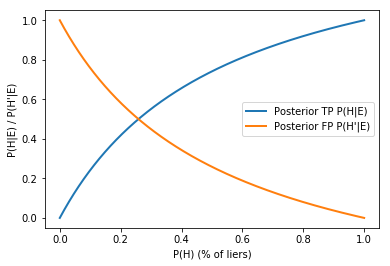

In [3]:
# Let's test different hypothesis
vPrH = np.arange(0.0, 1.0, 0.00001)
vfunc = np.vectorize(posterior)
vPrHE = vfunc(PrEH, vPrH, PrEnH)  # posterior of true positives
vPrnHE = 1 - vPrHE  # posterior of false positives

# Plot the two posteriors
fig, ax = plt.subplots()
ax.plot(vPrH, vPrHE, '-', lw=2, color='tab:blue')
ax.plot(vPrH, vPrnHE, '-', lw=2, color='tab:orange')
plt.xlabel("P(H) (% of liers)")
plt.ylabel("P(H|E) / P(H'|E)")
plt.legend(["Posterior TP P(H|E)", "Posterior FP P(H'|E)"])
#plt.title("Bayesian evaluation of performance")

We can annotate a specific hypothesis of 10% of people lying to pass the border:

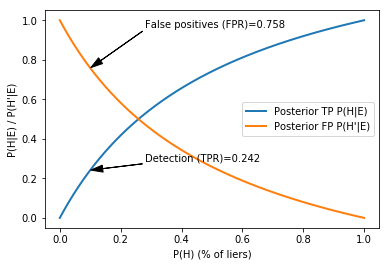

In [4]:
i = 10000
ax.annotate('Detection (TPR)={:.3f}'.format(vPrHE[i]),
            xy=(vPrH[i], vPrHE[i]),
            xycoords='data',
            xytext=(vPrH[i] + 0.2, vPrHE[i] + 0.1),
            textcoords='axes fraction',
            arrowprops=dict(facecolor='black',
                            shrink=0.01,
                            width=0.05,
                            headwidth=7),
            horizontalalignment='left',
            verticalalignment='top')

ax.annotate('False positives (FPR)={:.3f}'.format(vPrnHE[i]),
            xy=(vPrH[i], vPrnHE[i]),
            xycoords='data',
            xytext=(vPrH[i] + 0.2, vPrnHE[i] + 0.2),
            textcoords='axes fraction',
            arrowprops=dict(facecolor='black',
                            shrink=0.01,
                            width=0.05,
                            headwidth=7),
            horizontalalignment='left',
            verticalalignment='top')
fig

## Thermal analysis to screen refugees 

Last December the University of Granada published an interview with one of the authors of a system to spot liars based on *the Pinocchio Effect*. The methods uses thermography to detect increase of temperature in the nose of people who are lying while answering a question. The authors propose to use the tool to screen persons at refugee tamps to know "*what is the real purpose of people trying to cross borders between countries*" [7]. 

We can get the TP and FP from the journal publication [6]:

- $P(\text{+}\mid\text{Lie})=0.80$
- $P(\text{+}\mid\text{Non-lie})=0.20$

From the interview we don't have clear what the authors mean with *the real purpose of people* at refugee camps. Let's assume evaluating this purpose can be, for instance, to spot terrorists that would be hypothetically hidden in a refugee camp or are trying to enter Europe. So we want to know whether it would be useful to screen all the refugees using a lie detector to spot terrorists. 

We can calculate the prior of refugees that might be related to terrorism by using the data provided by the conservative think tank 'The Heritage Foundation' which claims, with no sources, that there where 44 refugees or asylum seekers involved in terrorist plots in Europe from 2014 to 2017. Note this is an unrealistic scenario with more people related to terrorism that actually are. In that period, we had 3,915,445 first time asylum applicants in Europe [9]. Then, we have the prior of refugees that during an interview will answer they are not terrorist, but they are: 

$P(\text{Lie})=\frac{44}{3915445}=0.000011$

So we can calculate the posterior of having an actual lier when the thermal analysis test is positive and the posterior of positive test for people telling the truth: 

\begin{align}
P(\text{Lier}\mid\text{+}) &= \frac{0.80 \times 0.000011}{0.80 \times 0.000011 + 0.20 \times 0.999988} \\
&\approx 0.004495\%\\
P(\text{No-lier}\mid\text{+}) &= 1-P(\text{Lier}\mid\text{+})=1-0.000045  \\
&\approx 99.99550\%
\end{align}

On the one hand, this means that *only 4 in a population of 1000 terrorists will be detected by the lie detector*. On the other hand, almost all the population of refugees (3915269) will be labeled as liers in an interview to spot terrorists. 

We can use the previous code to see how the model performs under different hypotheses:

Text(0.20001,0.90996,'False positives (FPR)=0.99996')

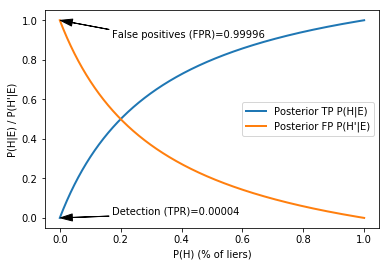

In [5]:
# Pr(E|H) Chance of a positive test (E) given there is a liar (H). This is the chance of a true positive.
PrEH = 0.80
# Chance of a positive test (E) given that the person wasn't a lying. This is the probability of a  false positive
PrEnH = 0.20

# Let's test different hypothesis
vPrH = np.arange(0.0, 1.0, 0.00001)
vfunc = np.vectorize(posterior)
vPrHE = vfunc(PrEH, vPrH, PrEnH)  # posterior of true positives
vPrnHE = 1 - vPrHE  # posterior of false positives

# Plot the two posteriors
fig, ax = plt.subplots()
ax.plot(vPrH, vPrHE, '-', lw=2, color='tab:blue')
ax.plot(vPrH, vPrnHE, '-', lw=2, color='tab:orange')
plt.xlabel("P(H) (% of liers)")
plt.ylabel("P(H|E) / P(H'|E)")
plt.legend(["Posterior TP P(H|E)", "Posterior FP P(H'|E)"])
#plt.title("Bayesian evaluation of performance")

i = 1
ax.annotate('Detection (TPR)={:.5f}'.format(vPrHE[i]),
            xy=(vPrH[i], vPrHE[i]),
            xycoords='data',
            xytext=(vPrH[i] + 0.2, vPrHE[i] + 0.1),
            textcoords='axes fraction',
            arrowprops=dict(facecolor='black',
                            shrink=0.01,
                            width=0.05,
                            headwidth=7),
            horizontalalignment='left',
            verticalalignment='top')

ax.annotate('False positives (FPR)={:.5f}'.format(vPrnHE[i]),
            xy=(vPrH[i], vPrnHE[i]),
            xycoords='data',
            xytext=(vPrH[i] + 0.2, vPrnHE[i] - 0.09),
            textcoords='axes fraction',
            arrowprops=dict(facecolor='black',
                            shrink=0.01,
                            width=0.05,
                            headwidth=7),
            horizontalalignment='left',
            verticalalignment='top')

## References: 
[0] National Research Council. 2003. The Polygraph and Lie Detection. Washington, DC: The National Academies Press. https://doi.org/10.17226/10420.

[1] BetterExplained, [An Intuitive (and Short) Explanation of Bayes’ Theorem](https://betterexplained.com/articles/an-intuitive-and-short-explanation-of-bayes-theorem/)

[2] Countbayesie.com, [Han Solo and Bayesian Priors](https://www.countbayesie.com/blog/2015/2/18/hans-solo-and-bayesian-priors)

[3] Wikipedia, [Base rate fallacy](https://en.wikipedia.org/wiki/Bayesian_inference)

[4] Wikipedia, [Bayesian inference](https://en.wikipedia.org/wiki/Base_rate_fallacy)

[4] Vera Wilde, [Refugee screening: a brief introduction (and a request for equipment)](http://www.scq.ubc.ca/refugee-screening-a-brief-introduction-and-a-request-for-equipment/)

[5] OrShea, James, Keeley Crockett, Wasiq Khan, Philippos Kindynis, Athos Antoniades, and Georgios Boultadakis. 2018. ‘Intelligent Deception Detection through Machine Based Interviewing’. In 2018 International Joint Conference on Neural Networks (IJCNN), 1–8. Rio de Janeiro, Brazil: IEEE. https://doi.org/10.1109/IJCNN.2018.8489392.

[6] Moliné, A., E. Dominguez, E. Salazar‐López, G. Gálvez‐García, J. Fernández‐Gómez, J. De la Fuente, O. Iborra, F. J. Tornay, and E. Gómez Milán. 2018. ‘The Mental Nose and the Pinocchio Effect: Thermography, Planning, Anxiety, and Lies’. Journal of Investigative Psychology and Offender Profiling 15 (2): 234–48. https://doi.org/10.1002/jip.1505.

[7] ‘Científicos de La UGR Investigan El Denominado “Efecto Pinocho” | Canal UGR’. n.d. Accessed 3 June 2019. https://perma.cc/799W-364A.

[8] Simcox, Robin. n.d. ‘The Asylum–Terror Nexus: How Europe Should Respond’, no. 3314: 12. https://www.heritage.org/sites/default/files/2018-06/BG3314.pdf

[9] https://ec.europa.eu/eurostat/en/web/products-datasets/-/MIGR_ASYAPPCTZA
